In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 1.3MB 11.3MB/s 
     |████████████████████████████████| 890kB 28.7MB/s 
     |████████████████████████████████| 1.1MB 30.3MB/s 
     |████████████████████████████████| 2.9MB 51.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101036 sha256=58bf0e0bfc6fc377fa4d2aeb97ac13d93cff4a1fda975c591018784280725ab3
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e3f6f07eb71d406e35b20ee36d59d8897e573b17da9becf42de760a220580f8a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer



In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [ ]:
all_files = glob.glob("./dataset_cleaning/*.pkl")
all_files.sort()
training_datasets = []

for filename in all_files:
    print(filename)
    df = pd.read_pickle(filename)
    training_datasets.append(df)
training_datasets = pd.concat(training_datasets)
training_datasets = training_datasets.sample(frac=1).reset_index(drop=True)

./dataset_cleaning/dataset1Cleaned.pkl
./dataset_cleaning/dataset2Cleaned.pkl
./dataset_cleaning/dataset3Cleaned.pkl
./dataset_cleaning/dataset4Cleaned.pkl
./dataset_cleaning/dataset5Cleaned.pkl
./dataset_cleaning/dataset6Cleaned.pkl
./dataset_cleaning/dataset7Cleaned.pkl


In [ ]:
datasets = []
datasets.append(training_datasets)
# datasets.append(pd.read_pickle('./dataset_test/dataset4Cleaned.pkl'))
# datasets.append(pd.read_pickle('./dataset_test/dataset7Cleaned.pkl'))


In [ ]:
#REMOVE
datasets = []
datasets.append(pd.read_pickle('./dataset_cleaning/dataset1Cleaned.pkl'))

In [ ]:
for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    ds['text_processed']=ds['text'].apply(text_processing)

Processing dataset 1


In [ ]:
# pd.to_pickle(datasets,'./datasets_processed_text.pkl')

In [ ]:
authors=pd.read_csv('./tweet_metadata_full.csv')
authors.drop_duplicates(subset=['id'], inplace=True)
users=pd.read_csv('./twitter_user_full.csv')
users.drop_duplicates(subset=['id'], inplace=True)

authors.drop(columns=['Unnamed: 0'], inplace=True)
users.drop(columns=["Unnamed: 0",'created_at', 'lang', 'name', 'screen_name', 'location','access'], inplace=True)
users.columns=['author_id', 'has_description', 'bio_has_url', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'statuses_count', 'protected',
       'verified', 'default_profile', 'default_profile_image']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mean=['retweet_count','favorite_count','followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']
median = ['tweet_type', 'has_description', 'bio_has_url', 'protected', 'verified','default_profile', 'default_profile_image']


for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    print(len(ds))
    ds = pd.merge(ds, authors, on='id', how='left')
    print(len(ds))
    ds.drop(ds.columns.difference(['id', 'Informativeness', 'text_processed', 'author_id', 'tweet_type', 'retweet_count', 'favorite_count']), 1, inplace=True)



    ds = pd.merge(ds, users, on='author_id', how='left')
    print(len(ds))

    for m in mean:
        ds[m][ds['Informativeness'] == 1] = ds[m][ds['Informativeness'] == 1].fillna((ds[m][ds['Informativeness'] == 1].mean()))
        ds[m][ds['Informativeness'] == 0] = ds[m][ds['Informativeness'] == 0].fillna((ds[m][ds['Informativeness'] == 0].mean()))
    print(len(ds))
    for m in median:
        ds[m][ds['Informativeness'] == 1] = ds[m][ds['Informativeness'] == 1].fillna((ds[m][ds['Informativeness'] == 1].value_counts().idxmax()))
        ds[m][ds['Informativeness'] == 0] = ds[m][ds['Informativeness'] == 0].fillna((ds[m][ds['Informativeness'] == 0].value_counts().idxmax()))
    print(len(ds))
    ds["has_description"] = ds["has_description"].apply(lambda x: 0 if x is np.nan else 1)
    ds["tweet_type"] = ds["tweet_type"].apply(lambda x: 0 if x =='tweet' else 1)
    ds["bio_has_url"] = ds["bio_has_url"].apply(lambda x: 0 if x is np.nan else 1)

    ds = ds.drop(columns=['author_id'])
    print(len(ds))

    datasets[i] = ds
    

Processing dataset 1
18159
18159
18159
18159
18159
18159


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
len(datasets[0])

19308

In [ ]:
# pd.to_pickle(datasets,'./datasets_user_merged.pkl')

In [ ]:
context=pd.read_csv('./context_annotations.csv')
context =context[["id",'domain_name' ,"entity_name"]]

In [ ]:
context.head()

,id,domain_name,entity_name
0,1006567036854599680,Video Game Conference,E3 2018
1,1006567036854599680,Video Game Conference,E3 2018
2,1006567069956083712,Brand,Nintendo
3,1006567069956083712,Product,Nintendo Direct
4,1006567069956083712,Video Game Conference,E3 2018


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Vevotize each sentance
vectorizer_entity = CountVectorizer()
vectorizer_entity.fit(context['entity_name'])

vectorizer_domain = CountVectorizer()
vectorizer_domain.fit(context['domain_name'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
grouped_entity = context.groupby(by= 'id')['entity_name'].apply(set)
grouped_domain = context.groupby(by= 'id')['domain_name'].apply(set)

grouped_entity_vectorized = grouped_entity.apply(lambda x: vectorizer_entity.transform(x).toarray().sum(axis=0))
grouped_domain_vectorized = grouped_domain.apply(lambda x: vectorizer_domain.transform(x).toarray().sum(axis=0))

In [ ]:
for i, ds in enumerate(datasets):

    print("Processing dataset: {}".format(i+1))
    ds = pd.merge(ds, grouped_domain_vectorized, on='id', how='left')
    tostack_domain =ds['domain_name'].apply(pd.Series)
    tostack_domain = tostack_domain.fillna(0)
    ds = pd.concat([ds, tostack_domain], axis=1)
    ds = pd.concat([ds,pd.DataFrame(np.zeros((tostack_domain.shape[0],len(vectorizer_domain.vocabulary_)-tostack_domain.shape[1])))], axis=1)
    
    ds = pd.merge(ds, grouped_entity_vectorized, on='id', how='left')
    tostack_entity =ds['entity_name'].apply(pd.Series)
    tostack_entity = tostack_entity.fillna(0)
    ds = pd.concat([ds, tostack_entity], axis=1)
    ds = pd.concat([ds,pd.DataFrame(np.zeros((tostack_entity.shape[0],len(vectorizer_entity.vocabulary_)-tostack_entity.shape[1])))], axis=1)
    
    
    ds.drop(columns=['domain_name', 'entity_name'], inplace=True)
    datasets[i] = ds

Processing dataset: 1
Processing dataset: 2
Processing dataset: 3
Processing dataset: 4
Processing dataset: 5
Processing dataset: 6


In [ ]:
for ds in datasets:
    print(ds.shape)

(19308, 17)


In [ ]:
pd.to_pickle(datasets,'./datasets_context_merged.pkl')

In [ ]:
datasets= pd.read_pickle('./datasets_context_merged.pkl')

In [ ]:
from sentence_transformers import SentenceTransformer
st_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

100%|██████████| 245M/245M [00:16<00:00, 15.0MB/s]


In [ ]:
bert_data =[]
for i,ds in enumerate(datasets):
    print("Calculating BERT embeddings for dataset {}".format(i+1))
    bert_data.append(st_model.encode(ds["text_processed"].values))

Calculating BERT embeddings for dataset 1


In [ ]:
pd.to_pickle(bert_data,'./bert_data.pkl')

In [ ]:
bert_data= pd.read_pickle('./bert_data.pkl')


In [ ]:
from sklearn.preprocessing import scale

full_datasets=[]
y_list =[]
for i in range(len(datasets)):
  print("Splitting dataset {}".format(i+1))
  y_list.append(datasets[i]["Informativeness"])
  stacked = np.hstack((bert_data[i], datasets[i].drop(columns=["id", "Informativeness", "text_processed"])))
  stacked_scaled = scale(stacked, with_mean= False, axis = 0)
  full_datasets.append(stacked_scaled)
  



Splitting dataset 1


In [ ]:
for ds in full_datasets:
    print(ds.shape)

(59054, 782)
(8274, 782)
(201, 782)


In [ ]:
# pd.to_pickle(full_datasets,'./full_datasets.pkl')
# pd.to_pickle(y_list,'./y_list.pkl')



In [ ]:
print(len(X_train))

827


In [ ]:
len(full_datasets[1])

8274

In [ ]:
pd.read_pickle('./dataset_cleaning/dataset1Cleaned.pkl').shape

(18159, 3)

In [ ]:
full_datasets[0].shape

(18159, 782)

In [ ]:
len(y_test)

5448

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_datasets[0], y_list[0], test_size=0.30, random_state=69)

# X_train_disaster, X_test_disaster, y_train_disaster, y_test_disaster = train_test_split(full_datasets[0], y_list[0], test_size=0.95, random_state=22)

# X_train_mixed=np.append(X_train, X_train_disaster, axis=0)
# y_train_mixed=np.append(y_train, y_train_disaster, axis=0)

# print("Xtrain len: {}, mixed len: {}".format(len(X_train), len(X_train_mixed)))



parameters= {
'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
'normalize': [True, False]

}
model = RidgeClassifier()
gs_clf = GridSearchCV(model, parameters,scoring='f1',cv=10, n_jobs=-1, verbose=10)
gs_clf = gs_clf.fit(X_train, y_train)

print("non_mixed: ",gs_clf.score(X_test, y_test))

# model = RidgeClassifier()
# gs_clf = GridSearchCV(model, parameters,scoring='roc_auc',cv=10, n_jobs=-1, verbose=10)
# gs_clf = gs_clf.fit(X_train_mixed, y_train_mixed)

# print("Mixed: ", gs_clf.score(X_test, y_test))


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

non_mixed:  0.8730950401773345


In [ ]:
coefs_with_fns = sorted(zip(gs_clf.best_estimator_.decision_function(full_datasets[0]), pd.read_pickle('./dataset_cleaning/dataset1Cleaned.pkl')["text"], pd.read_pickle('./dataset_cleaning/dataset1Cleaned.pkl')["Informativeness"]))
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word', 'Informativeness'
df.sort_values(by='coefficient', ascending=False).head(20)

,coefficient,word,Informativeness
18158,1.966714,Authorities: Fertilizer plant explodes near Wa...,1
18157,1.962775,#FloodsPH: Cubao underpass now closed to traff...,1
18156,1.909138,Breaking News:Shots fired out here in LAX airp...,1
18155,1.896353,Update: Agencies report strong earthquake that...,1
18154,1.892496,News: Typhoon Pablo makes landfall in Philipp...,1
18153,1.862204,Bangladesh factory collapse families search tr...,1
18152,1.848624,#sghaze: the 3-hour PSI at 290 at 9pm has exce...,1
18151,1.838406,JUST IN: More than 100 patients have been evac...,1
18150,1.815691,"“@rodmagaru: Use #RescuePH for help rescue, #R...",1
18149,1.795567,BREAKING: #PabloPH enters PH Area of Responsib...,1


In [ ]:
tot roc: 0.8665521913839828
tot f1: 0.8767032015191392
crisisnlp f1: 0.883

In [ ]:
results=[]
for i,ds_train in enumerate(datasets[:1]):

    print("Training on Dataset {}".format(i+1))
    row=[]

    
    X_train = full_datasets[i]
    y_train = y_list[i]

    parameters= {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
        'normalize': [True, False]

    }
    model = RidgeClassifier()
    gs_clf = GridSearchCV(model, parameters,scoring='roc_auc',cv=10, n_jobs=-1, verbose=10)
    gs_clf = gs_clf.fit(X_train, y_train)

    for j,ds_test in enumerate(datasets):

        print("testing on Dataset {}".format(j+1))
        
        X_test = full_datasets[j]
        y_test = y_list[j]


        row.append(gs_clf.score(X_test, y_test))
    results.append(row)

Training on Dataset 1
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4

testing on Dataset 1
testing on Dataset 2
testing on Dataset 3


In [ ]:
print(results)

[[0.8270141840398424, 0.587855214085308, 0.6320330969267139]]


In [ ]:
dataset_names={0:"crisislex",1:"crisisnlp_crisismmd",2:"news_notNews",3:"Covid_WNUT", 4:"crisisnlp_Sandy_Japolin", 5:"crisisnlp_19Crisis"}

df = pd.DataFrame(results)
df.columns= map( lambda x: dataset_names[x],df.columns)
df.index= map( lambda x: dataset_names[x],df.index)

Text(0.5, 1.0, 'Distilbert with user features and context not dropping anything')

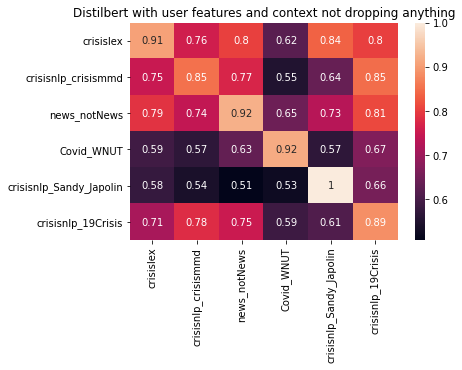

In [ ]:
sns.heatmap(df, annot=True).set_title('Distilbert with user features and context not dropping anything')
